In [115]:
import pandas as pd
import database_service
from database_service import Database
import json
import psycopg2
from psycopg2 import sql
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



### Question: Provide a comprehensive overview of the database tables and the nature of the data you will be handling

### Answer:

```
We haev two table: Clients and Loans
Clients table:
    - this table hold the all user details and there status, credit limit, interest rate on which they can get the loan and other details.
Loans table:
    - When ever a loan is issued to a user we get one entry in this table.
    - This table hold the Loan related details like, loan amount, due amount due date,amount paid, and loan status.

Both the table are linked using User_id column, which is a primary key for Clients table and act as foreign key for Loans table.
```

### Question: Identify the best month in terms of loan issuance. What was the quantity and amount lent in each month?

SQL Query : 

```
with cte as (select 
    extract(year from created_at) as years,
    extract(month from created_at) as months,
    count(user_id) as cnt,
    sum(loan_amount) as total_loan_amount,
    sum(due_amount - (loan_amount + tax)) as expected_earning
    from loans 
    group by years, months
)
select * , 100*expected_earning/total_loan_amount as per from cte;
```

In [130]:
config = json.load(open('config.json'))
db = Database(config['db'])

sql_query = sql.SQL('''
with cte as (select 
    extract(year from created_at) as years,
    extract(month from created_at) as months,
    count(user_id) as cnt,
    sum(loan_amount) as total_loan_amount,
    sum(due_amount - (loan_amount + tax)) as expected_earning
    from loans 
    group by years, months
)
select * , 100*expected_earning/total_loan_amount as per from cte;
''')
results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=["year", "month", "Number_of_user","Total_loan_amount", "Expected_earning", "Earning_Percentage"])

df.head()

,year,month,Number_of_user,Total_loan_amount,Expected_earning,Earning_Percentage
0,2020,1,16,348731.0,46029.85,13.199242
1,2020,2,59,1723978.0,226266.39,13.124668
2,2020,3,107,2460062.0,345956.11,14.062902
3,2020,4,145,3465180.0,432084.40,12.469320
4,2020,5,161,4323270.0,570018.46,13.184892


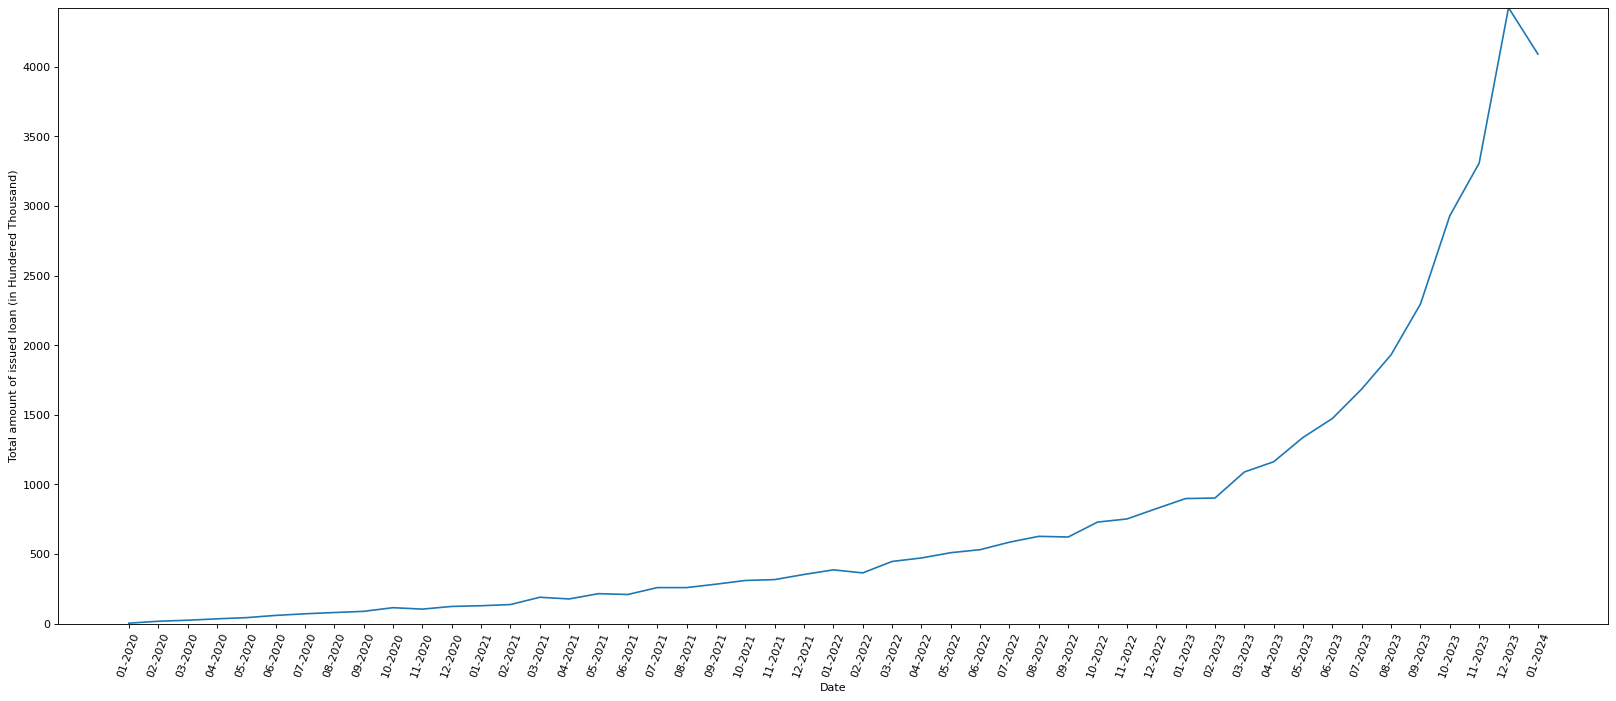

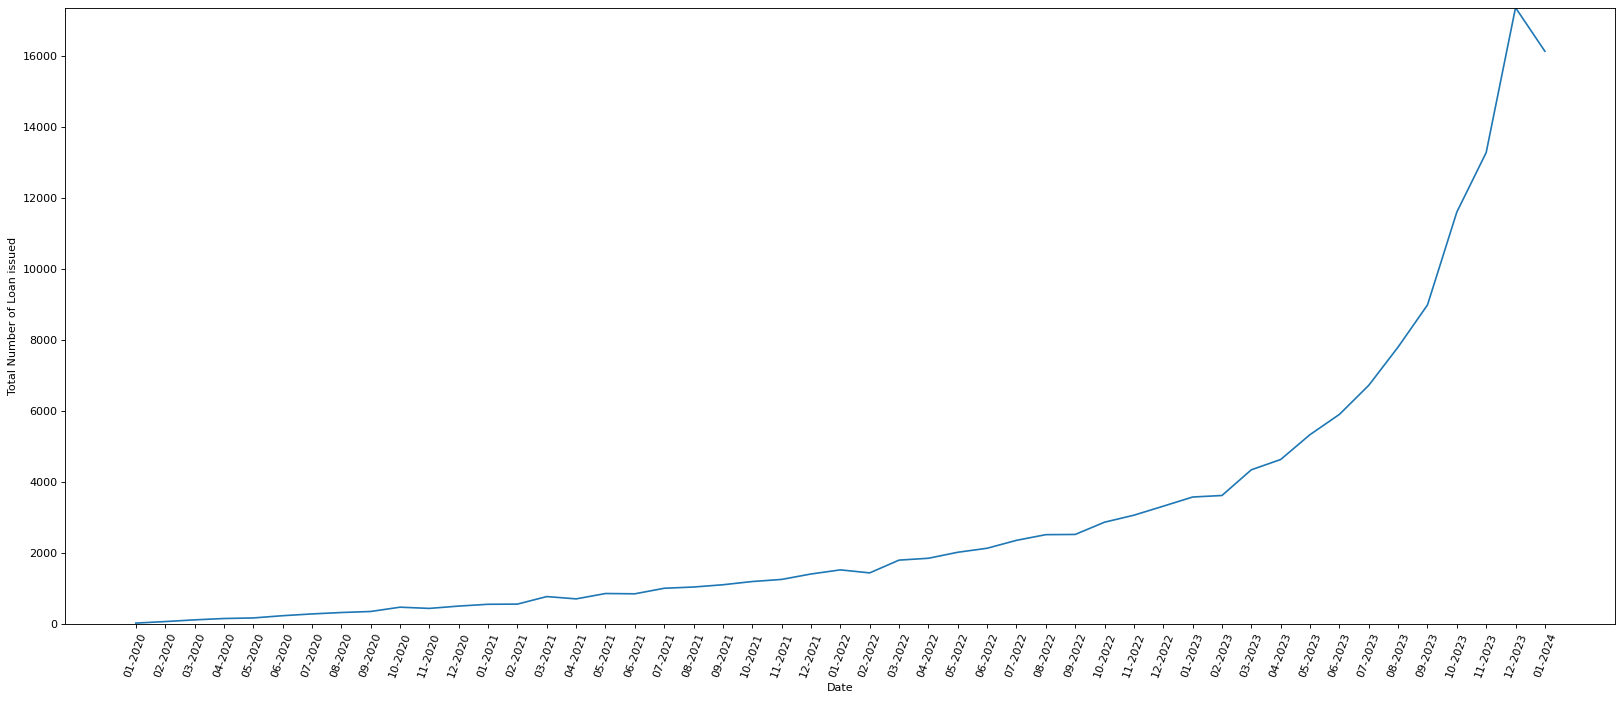

In [76]:
df['Total_loan_amount'] = df['Total_loan_amount']/100000
df['Expected_earning'] = df['Expected_earning']/100000

df['date'] = df['month'].map(str)+ '-' +df['year'].map(str)
df['date'] = pd.to_datetime(df['date'], format='%m-%Y').dt.strftime('%m-%Y')
#fig, ax = plt.subplots()
figure(figsize=(25, 10), dpi=80)
plt.plot(df['date'], df['Total_loan_amount'])
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Total amount of issued loan (in Hundered Thousand)")
plt.ylim(0, df['Total_loan_amount'].max())
plt.show()

figure(figsize=(25, 10), dpi=80)
plt.plot(df['date'], df['Number_of_user'])
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Total Number of Loan issued")
plt.ylim(0, df['Number_of_user'].max())
plt.show()

##### Best month is  Dec 2023, most number of loan is issued and highest loan amount issued.

### Question: Determine which batch had the best overall adherence?

SQL Query:
```
with cte as (
    select batch, count(l.loan_id) as loan_issued, 
    count(case when l.status = 'default' then 1 else null end) as default_cnt, 
    count(case when l.status = 'paid' then 1 else null end) as paid_cnt, 
    count(case when l.status = 'ongoing' then 1 else null end) as ongoing_cnt, 
    sum(loan_amount) as issued_amount,
    sum(case when l.status = 'default' then loan_amount else 0 end)as default_amount, 
    sum(case when l.status = 'paid' then loan_amount else 0 end)as paid_amount, 
    sum(case when l.status = 'ongoing' then loan_amount else 0 end)as ongoing_amount
    from clients c join loans l
    on c.user_id = l.user_id
    group by batch
)
select batch, loan_issued,
default_cnt*100.0/loan_issued as default_rate,
from cte;

```

In [77]:
sql_query = sql.SQL('''
with cte as (
    select batch, count(l.loan_id) as loan_issued, 
    count(case when l.status = 'default' then 1 else null end) as default_cnt, 
    count(case when l.status = 'paid' then 1 else null end) as paid_cnt, 
    count(case when l.status = 'ongoing' then 1 else null end) as ongoing_cnt, 
    sum(loan_amount) as issued_amount,
    sum(case when l.status = 'default' then loan_amount else 0 end)as default_amount, 
    sum(case when l.status = 'paid' then loan_amount else 0 end)as paid_amount, 
    sum(case when l.status = 'ongoing' then loan_amount else 0 end)as ongoing_amount
    from clients c join loans l
    on c.user_id = l.user_id
    group by batch
)
select batch, loan_issued, default_cnt,
(default_cnt*100.0/loan_issued) as default_rate
from cte;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['batch', 'Number_of_loan_issued','Default_count', 'Default_rate'])
df.head()

,batch,Number_of_loan_issued,Default_count,Default_rate
0,1,98365,7906,8.0374116809840899
1,2,37415,3226,8.6222103434451423
2,3,8958,718,8.0151819602589864
3,4,5971,491,8.2230782113548819


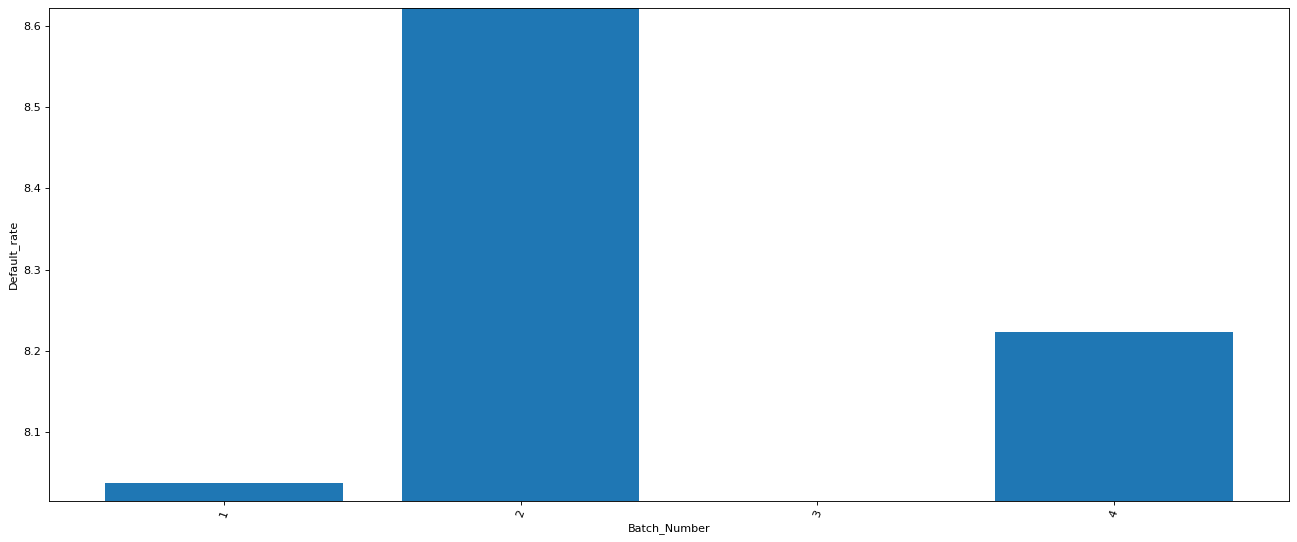

In [78]:
df['batch'] = df['batch'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.bar(df['batch'], df['Default_rate'])
plt.xticks(df['batch'], rotation=70)
plt.xlabel("Batch_Number")
plt.ylabel("Default_rate")

plt.ylim(df['Default_rate'].min(), df['Default_rate'].max())
plt.show()

##### Batch 3 has best overall adhereance with lowest default rate

### Question: Do different interest rates lead to different loan outcomes in terms of default rate?

SQL Query:
```
select interest_rate, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by interest_rate;
```

In [79]:
sql_query = sql.SQL('''
select interest_rate, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by interest_rate;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['Interest_rate', 'Number_of_loan_issued','Default_count', 'Default_rate'])
df.head()

,Interest_rate,Number_of_loan_issued,Default_count,Default_rate
0,20,38021,3061,8.0508140238289366
1,30,37421,3077,8.2226557280671281
2,70,37201,3060,8.2255853337275880
3,90,38066,3143,8.2567120264803236


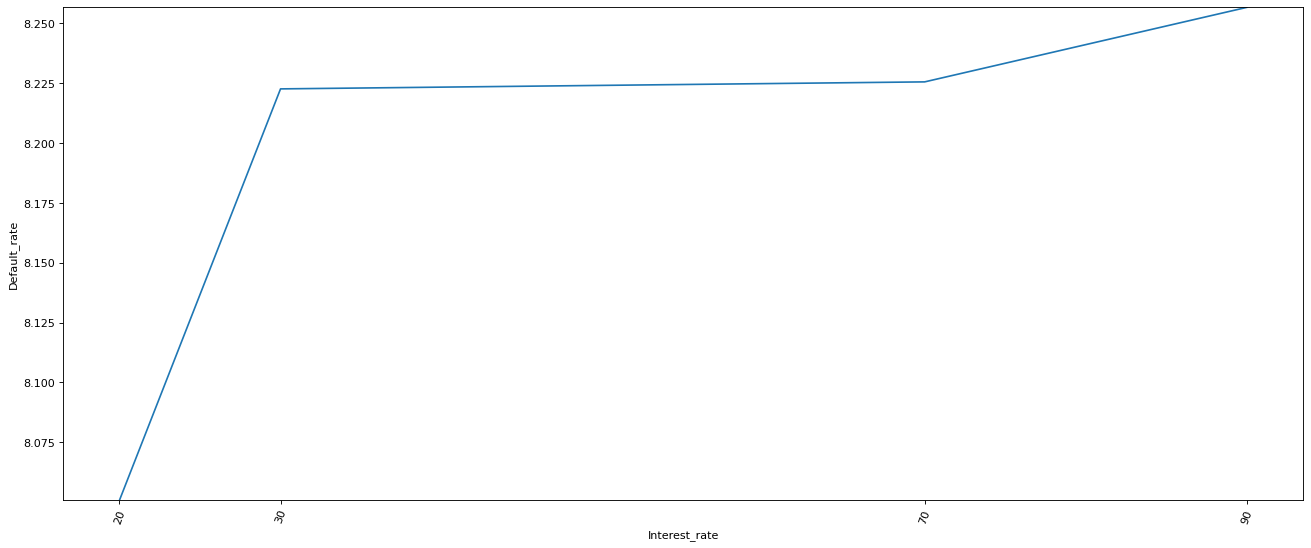

In [80]:
figure(figsize=(20, 8), dpi=80)
plt.plot(df['Interest_rate'], df['Default_rate'])
plt.xticks(df['Interest_rate'], rotation=70)
plt.xlabel("Interest_rate")
plt.ylabel("Default_rate")

plt.ylim(df['Default_rate'].min(), df['Default_rate'].max())
plt.show()

##### These is differest in default rate based on interest rate but difference is very small. Lowers interest rate have lowest default rate

### Question : Rank the best 10 and 10 worst clients. Explain your methodology for constructing this ranking.

##### To find the top 10 best client:
```

Here I am creating one score for all the clients base 3 factors:
    - Loan Amount paid taken
    - repayment ratio i.e. paid_amount/loan_amount
    - how quick they pay the money back.
As irrespective of the how quick they pay the loan back , they need to pay the full interest for 90 days. Then if some one returning the money in 20 days instead of 90 days, we can use that money to give loan again.
Weight of there three factor in score is :
    - Loan Amount paid taken - 0.5
    - repayment ratio- 0.2
    - how quick they pay the money back. - 0.3
```

SQL query:
```
with cte as (
    select c.user_id, count(loan_id) as cnt, sum(loan_amount) as total_due_amount, 
        sum(case when l.status = 'paid' then amount_paid else 0 end) as total_paid_amount,
        sum(case when l.status = 'paid' then amount_paid else 0 end)/sum(loan_amount) as repayment_ratio,
        extract(day from avg(paid_at - l.created_at)) as diff
    from clients c join loans l
    on c.user_id = l.user_id
    where c.status = 'approved'
    group by c.user_id
),
normalized_data as (
    select *, 
    ((total_paid_amount - min(total_paid_amount) over()) / (max(total_paid_amount) over() - min(total_paid_amount) over()))  as paid_amount_normalize,
    ((repayment_ratio - min(repayment_ratio) over()) / (max(repayment_ratio) over() - min(repayment_ratio) over()))  as repayment_ratio_normalize ,
    ((max(diff) over() - diff) / (max(diff) over() - min(diff) over()))  as diff_normalize 
    from cte
    where diff is not null
)
select user_id,round(cast(total_paid_amount as numeric), 2), round(cast(repayment_ratio as numeric), 2), diff as avg_return_time,
round(cast(((0.5*paid_amount_normalize) + (0.3*diff_normalize) + (0.2*repayment_ratio_normalize)) as numeric), 2) as score
from normalized_data
order by score  desc limit 10;
```


In [81]:
sql_query = sql.SQL('''
with cte as (
    select c.user_id, count(loan_id) as cnt, sum(loan_amount) as total_due_amount, 
        sum(case when l.status = 'paid' then amount_paid else 0 end) as total_paid_amount,
        sum(case when l.status = 'paid' then amount_paid else 0 end)/sum(loan_amount) as repayment_ratio,
        extract(day from avg(paid_at - l.created_at)) as diff
    from clients c join loans l
    on c.user_id = l.user_id
    where c.status = 'approved'
    group by c.user_id
),
normalized_data as (
    select *, 
    ((total_paid_amount - min(total_paid_amount) over()) / (max(total_paid_amount) over() - min(total_paid_amount) over()))  as paid_amount_normalize,
    ((repayment_ratio - min(repayment_ratio) over()) / (max(repayment_ratio) over() - min(repayment_ratio) over()))  as repayment_ratio_normalize ,
    ((max(diff) over() - diff) / (max(diff) over() - min(diff) over()))  as diff_normalize 
    from cte
    where diff is not null
)
select user_id,round(cast(total_paid_amount as numeric), 2), round(cast(repayment_ratio as numeric), 2), diff as avg_return_time,
round(cast(((0.5*paid_amount_normalize) + (0.3*diff_normalize) + (0.2*repayment_ratio_normalize)) as numeric), 2) as score
from normalized_data
order by score  desc limit 10;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['user_id', 'Total_amount_paid','payment_ratio', 'Averge_time_taken', 'Score'])
df.head()

,user_id,Total_amount_paid,payment_ratio,Averge_time_taken,Score
0,77087,565668.55,1.10,35,0.86
1,44244,447887.79,1.08,31,0.77
2,22476,411763.41,1.03,21,0.76
3,2473,345422.07,1.24,13,0.76
4,33161,357220.17,1.19,17,0.75


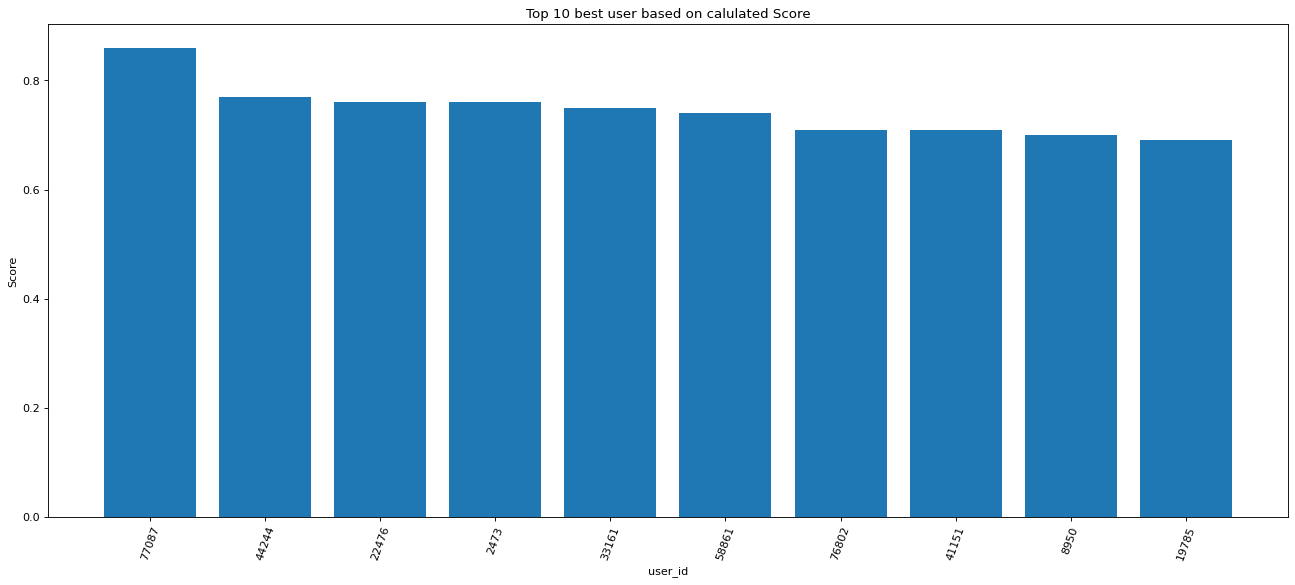

In [82]:
df['user_id'] = df['user_id'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.bar(df['user_id'].astype(str), df['Score'])
plt.xticks(df['user_id'], rotation=70)
plt.xlabel("user_id")
plt.ylabel("Score")
plt.title("Top 10 best user based on calulated Score")
#plt.ylim(df['Score'].min(), df['Score'].max())
plt.show()

##### To find the 10 worst client:
I am checking for those who have the largest unpaid due_amount and are marked as defaulters because these are the clients that contributed to losses for the company

SQL Query:
```
select c.user_id , sum(due_amount - amount_paid) as unpaid_amount
from clients c join loans l
on c.user_id = l.user_id
where l.status = 'default'
group by c.user_id
order by unpaid_amount desc limit 10;
```

In [83]:
sql_query = sql.SQL('''
select c.user_id , sum(due_amount - amount_paid) as unpaid_amount
from clients c join loans l
on c.user_id = l.user_id
where l.status = 'default'
group by c.user_id
order by unpaid_amount desc limit 10;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['user_id', 'unpaid_amount'])
df.head()

,user_id,unpaid_amount
0,66899,115929.06
1,30138,114799.27
2,8934,107698.26
3,89832,107466.28
4,20291,106707.15


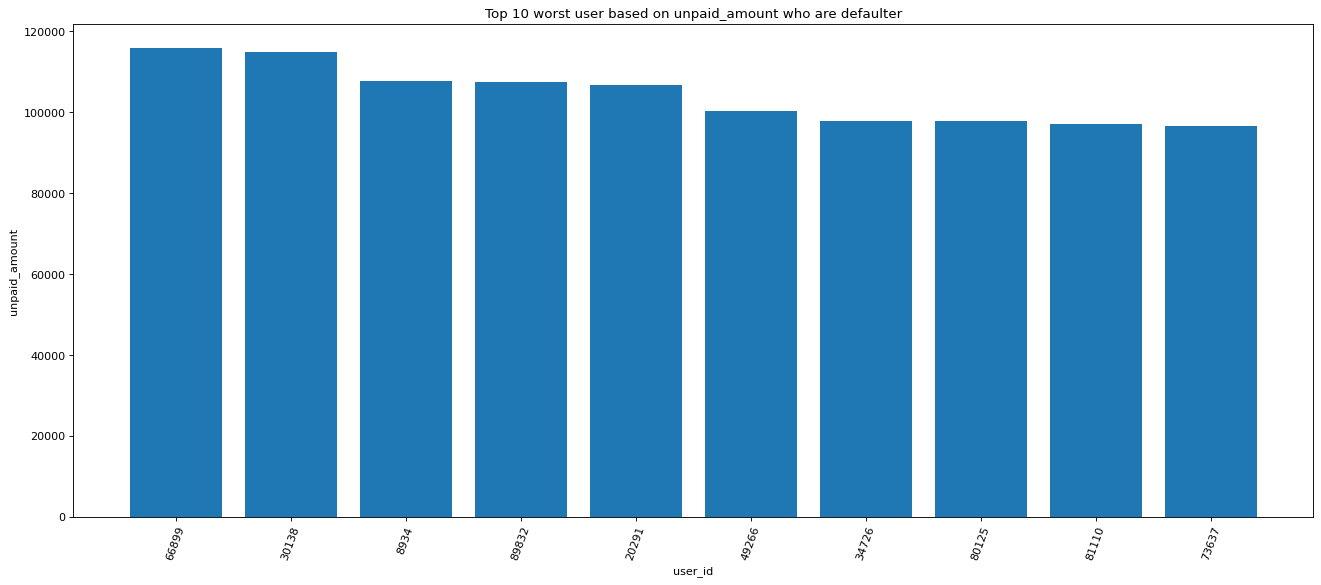

In [84]:
df['user_id'] = df['user_id'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.bar(df['user_id'].astype(str), df['unpaid_amount'])
plt.xticks(df['user_id'], rotation=70)
plt.xlabel("user_id")
plt.ylabel("unpaid_amount")
plt.title("Top 10 worst user based on unpaid_amount who are defaulter")
#plt.ylim(df['Score'].min(), df['Score'].max())
plt.show()

### Question: What is the default rate by month and by batch?

##### Default rate by batch

SQL query:
```
select c.batch, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by c.batch;
```

In [85]:
sql_query = sql.SQL('''
select c.batch, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by c.batch;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['batch', 'Number_of_loan_issued','Default_count', 'Default_rate'])
df.head()

,batch,Number_of_loan_issued,Default_count,Default_rate
0,1,98365,7906,8.0374116809840899
1,2,37415,3226,8.6222103434451423
2,3,8958,718,8.0151819602589864
3,4,5971,491,8.2230782113548819


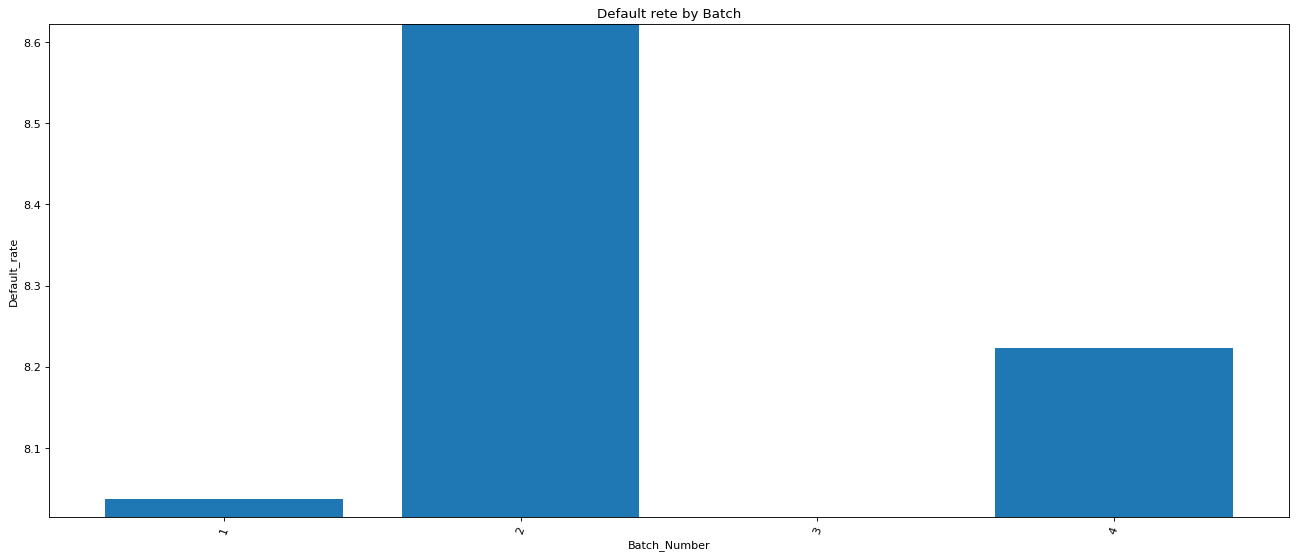

In [86]:
df['batch'] = df['batch'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.bar(df['batch'], df['Default_rate'])
plt.xticks(df['batch'], rotation=70)
plt.xlabel("Batch_Number")
plt.ylabel("Default_rate")
plt.title("Default rete by Batch")
plt.ylim(df['Default_rate'].min(), df['Default_rate'].max())
plt.show()

##### Default rate by month

SQL query:
```
select extract(year from l.created_at) as years,
extract(month from l.created_at) as months, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by years, months;
```

In [87]:
sql_query = sql.SQL('''
select extract(year from l.created_at) as years,
extract(month from l.created_at) as months, count(l.loan_id) as loan_issued, 
count(case when l.status = 'default' then 1 else null end) as default_cnt,
count(case when l.status = 'default' then 1 else null end)*100.0/count(l.loan_id) as default_rate
from clients c join loans l
on c.user_id = l.user_id
group by years, months;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['year', 'month', 'Number_of_loan_issued','Default_count', 'Default_rate'])
df.head()

,year,month,Number_of_loan_issued,Default_count,Default_rate
0,2020,1,16,3,18.7500000000000000
1,2020,2,59,9,15.2542372881355932
2,2020,3,107,11,10.2803738317757009
3,2020,4,145,12,8.2758620689655172
4,2020,5,161,26,16.1490683229813665


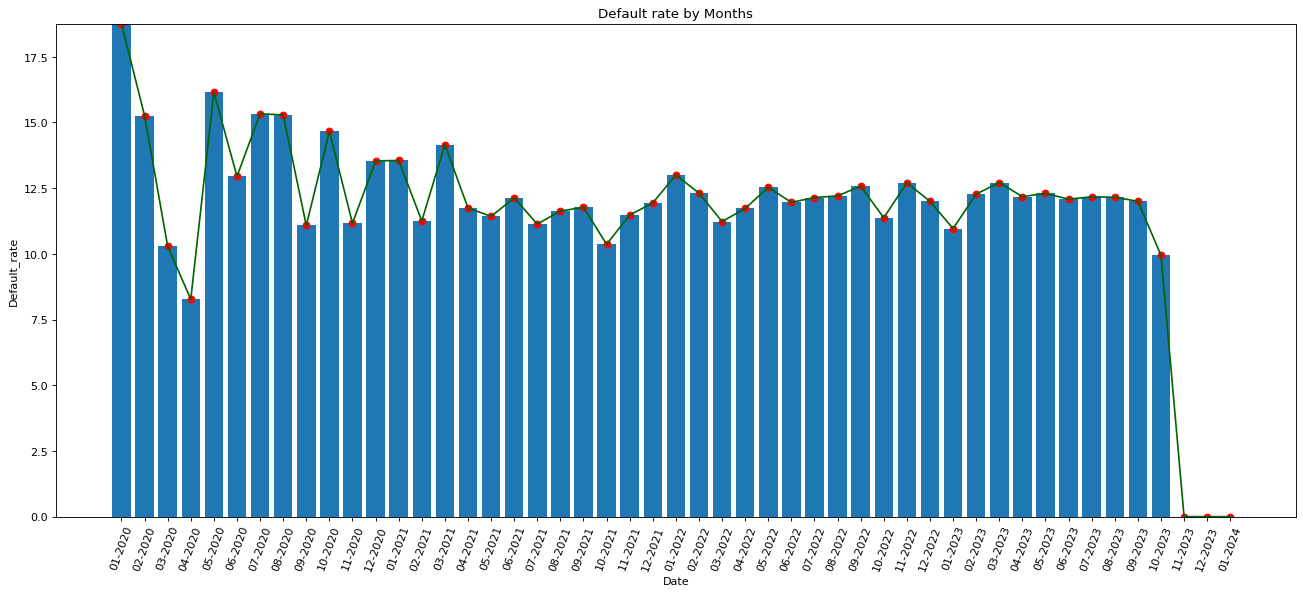

In [88]:
df['date'] = df['month'].map(str)+ '-' +df['year'].map(str)
df['date'] = pd.to_datetime(df['date'], format='%m-%Y').dt.strftime('%m-%Y')
figure(figsize=(20, 8), dpi=80)
plt.bar(df['date'], df['Default_rate'])
plt.plot(df['date'], df['Default_rate'], color='darkgreen')
plt.scatter(df['date'], df['Default_rate'], color='red')
plt.xticks(df['date'], rotation=70)
plt.xlabel("Date")
plt.ylabel("Default_rate")
plt.title("Default rate by Months")
plt.ylim(df['Default_rate'].min(), df['Default_rate'].max())
plt.show()

### Question: Assess the profitability of this operation. Provide an analysis of the operation's timeline.

SQL Query:
```
with cte as (
    select 
    extract(year from created_at) as years,
    extract(month from created_at) as months,
    count(user_id) as cnt,
    sum(loan_amount) as total_loan_amount,
    sum(amount_paid) as total_amount_paid,
    sum(amount_paid - (loan_amount + tax)) as total_earning,
    sum(case when status = 'default' then due_amount else 0 end) as default_amount
    from loans 
    group by years, months
),
with_lags as (select *,lag(total_loan_amount) over(order by years, months) as previous_month, 
			  (100*total_earning/total_loan_amount)as earning_rate
			  from cte
)

select years, months, cnt as Numeber_of_loan_issued, round(CAST(total_loan_amount as numeric), 2) as total_loan_amoun,
round(CAST(default_amount as numeric), 2) as default_amount, 
round(CAST(total_amount_paid as numeric), 2) as total_amound_paid,
round(CAST(total_earning as numeric), 2) as total_earning,
round(CAST(earning_rate as numeric), 2) as earning_rate,  
round(CAST(((total_loan_amount -  previous_month)*100/previous_month) as numeric), 2) as growth_percentage
from with_lags;
```

In [104]:
sql_query = sql.SQL('''
with cte as (
    select 
    extract(year from created_at) as years,
    extract(month from created_at) as months,
    count(user_id) as cnt,
    sum(loan_amount) as total_loan_amount,
    sum(amount_paid) as total_amount_paid,
    sum(amount_paid - (loan_amount + tax)) as total_earning,
    sum(case when status = 'default' then due_amount else 0 end) as default_amount
    from loans 
    group by years, months
),
with_lags as (select *,lag(total_loan_amount) over(order by years, months) as previous_month, 
			  (100*total_earning/total_loan_amount)as earning_rate
			  from cte
)

select years, months, cnt as Numeber_of_loan_issued, round(CAST(total_loan_amount as numeric), 2) as total_loan_amoun,
round(CAST(default_amount as numeric), 2) as default_amount, 
round(CAST(total_amount_paid as numeric), 2) as total_amound_paid,
round(CAST(total_earning as numeric), 2) as total_earning,
round(CAST(earning_rate as numeric), 2) as earning_rate

from with_lags;
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['year', 'month', 'Number_of_loan_issued','Total_loan_amount','Default_amount', 'total_amount_paid', 'total_earning', 'Earning_rate'])
df.head()

,year,month,Number_of_loan_issued,Total_loan_amount,Default_amount,total_amount_paid,total_earning,Earning_rate
0,2020,1,16,348731.00,63760.42,347929.04,-4700.78,-1.35
1,2020,2,59,1723978.00,403698.04,1710588.95,-32663.13,-1.89
2,2020,3,107,2460062.00,215836.55,2765467.42,277901.93,11.30
3,2020,4,145,3465180.00,528508.25,3758226.39,254305.69,7.34
4,2020,5,161,4323270.00,878974.64,4560709.33,189105.16,4.37


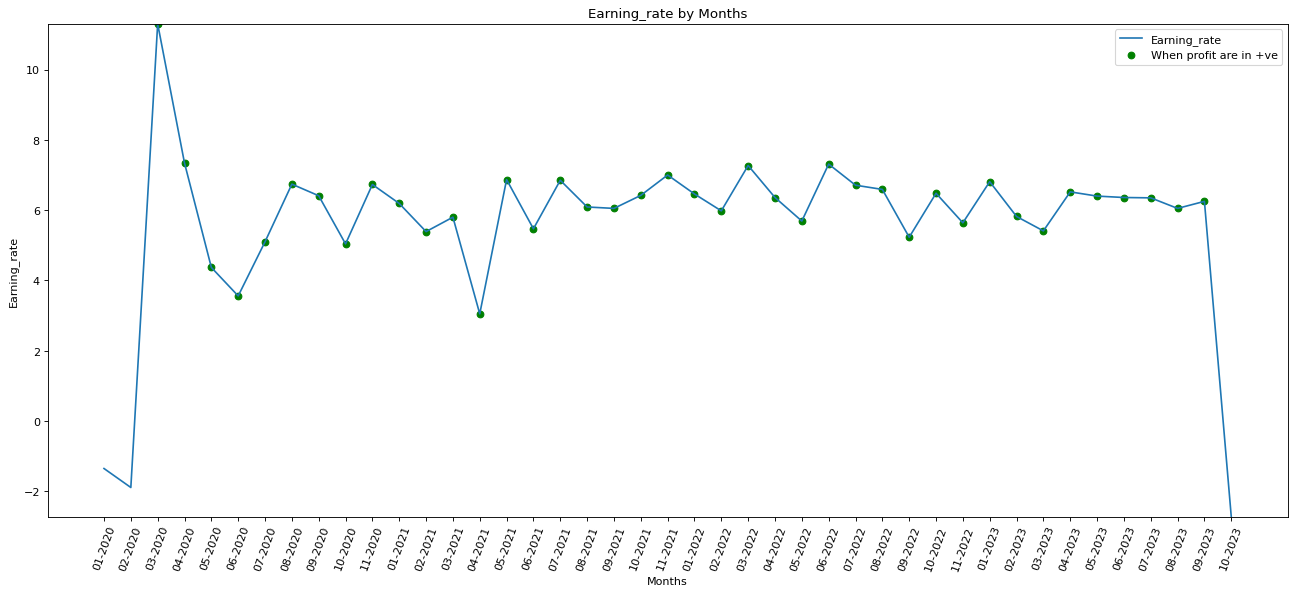

In [107]:
df['date'] = df['month'].map(str)+ '-' +df['year'].map(str)
df['date'] = pd.to_datetime(df['date'], format='%m-%Y').dt.strftime('%m-%Y')
df = df[(df['date'] <'11-2023')&(df['year'] <2024)]
profit_df = df[df['Earning_rate'] >0]
figure(figsize=(20, 8), dpi=80)
plt.plot(df['date'], df['Earning_rate'])
plt.scatter(profit_df['date'], profit_df['Earning_rate'], color='green')

plt.xticks(df['date'], rotation=70)
plt.xlabel("Months")
plt.ylabel("Earning_rate")
plt.title("Earning_rate by Months")
plt.legend(["Earning_rate","When profit are in +ve"])
plt.ylim(df['Earning_rate'].min(), df['Earning_rate'].max())
plt.show()

##### Profit are very small generally between 4-7%. Need to work on how to reduce the default rate as we can see 13% default rate.

In [126]:
sql_query = sql.SQL('''
with cte as (
    select 
    extract(year from created_at) as years,
    count(user_id) as cnt,
    sum(loan_amount) as total_loan_amount,
    sum(amount_paid) as total_amount_paid,
    sum(amount_paid - (loan_amount + tax)) as total_earning,
    sum(case when status = 'default' then due_amount else 0 end) as default_amount
    from loans 
    group by years
),
with_lags as (select *,lag(total_loan_amount) over(order by years) as previous_month, 
			  (100*total_earning/total_loan_amount)as earning_rate
			  from cte
)

select years,
       round(CAST(((total_loan_amount -  previous_month)*100/previous_month) as numeric), 2) as growth_percentage
from with_lags
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['year', 'growth_percentage'])
df.iloc[0,1] = 0
df.head()

,year,growth_percentage
0,2020,0
1,2021,271.32
2,2022,141.35
3,2023,242.02
4,2024,-82.55


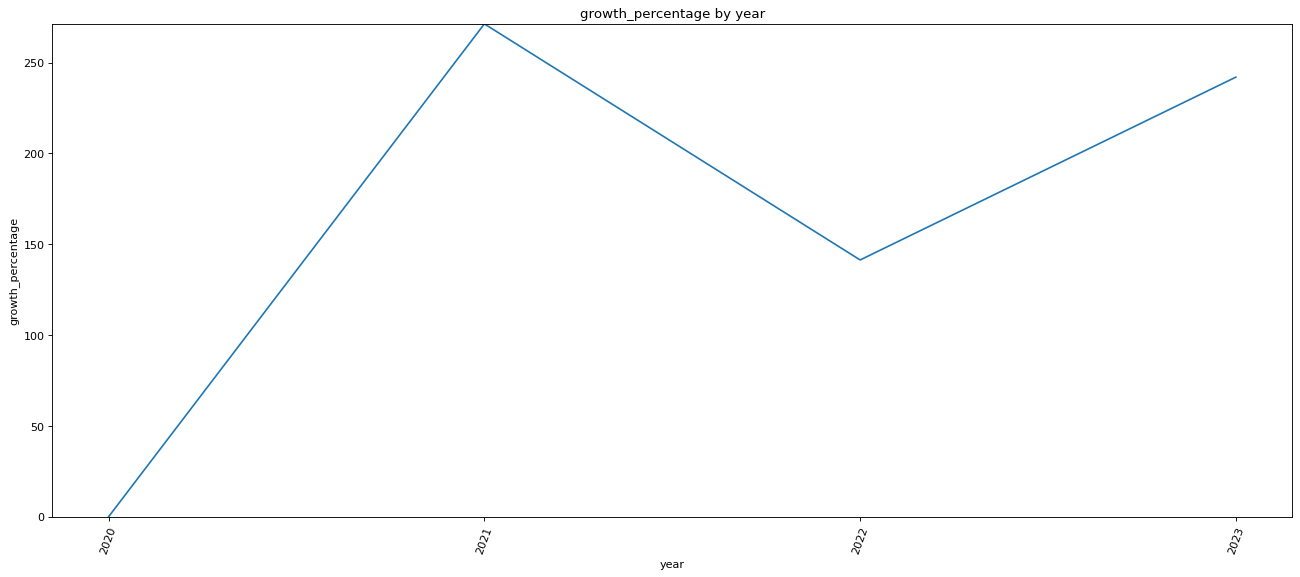

In [127]:
df = df[df['year'] < 2024]
df['year'] = df['year'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.plot(df['year'], df['growth_percentage'])
plt.xticks(df['year'], rotation=70)
plt.xlabel("year")
plt.ylabel("growth_percentage")
plt.title("growth_percentage by year")
plt.ylim(df['growth_percentage'].min(), df['growth_percentage'].max())
plt.show()

In [139]:
sql_query = sql.SQL('''
select extract(year from created_at) as years,
    sum(loan_amount)/100000 as loan_amount_issued
from loans
group by years
''')

results = db.get_output(sql_query)
#print(results)
df = pd.DataFrame(results, columns=['year', 'Total_loan_amount_issued'])
df = df.sort_values('year')

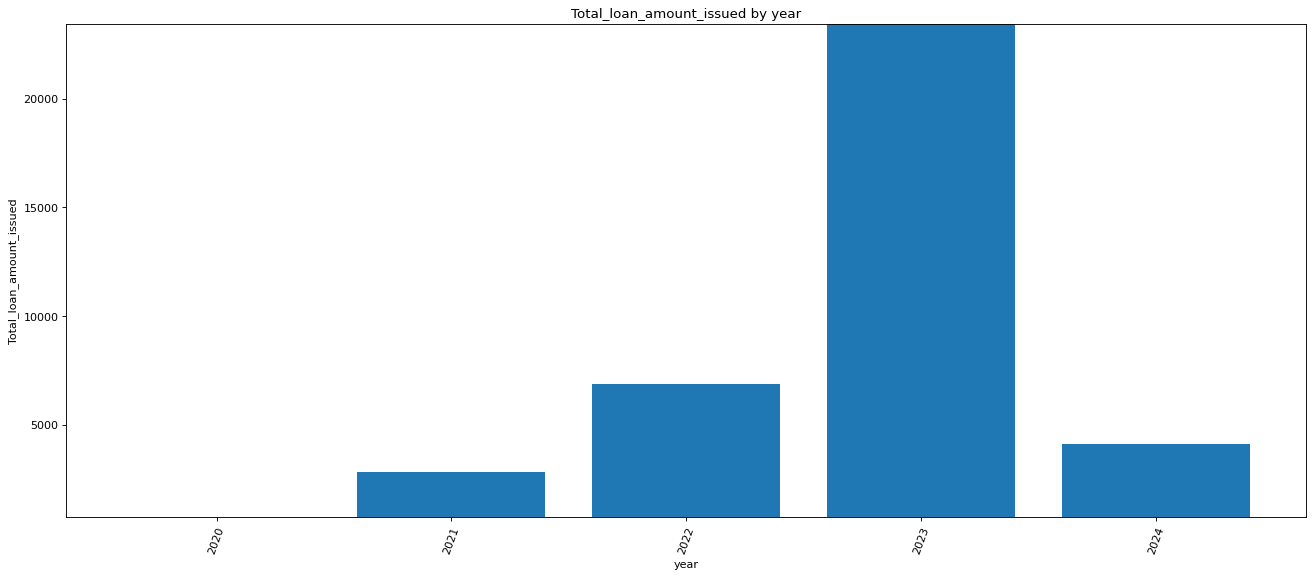

In [141]:

df['year'] = df['year'].astype(str)
figure(figsize=(20, 8), dpi=80)
plt.bar(df['year'], df['Total_loan_amount_issued'])
plt.xticks(df['year'], rotation=70)
plt.xlabel("year")
plt.ylabel("Total_loan_amount_issued")
plt.title("Total_loan_amount_issued by year")
plt.ylim(df['Total_loan_amount_issued'].min(), df['Total_loan_amount_issued'].max())
plt.show()

AS Seen in the bar chart Total Loan amount issued is growith with more then 150% every year. 
Here for 2024 we only have Jan data that's when its Total Loan amount issued is less.

##### Over total loan amount disbursed is growing by more then 150% every year.